In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import numpy as np
import random

physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) >= 1:
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1.1 What type of image maximizes each convolutional filter?

## 1.1a Load a pretrained VGG16 model without the top

In [2]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.trainable = False

base_model.summary()
for layer in base_model.layers:
    if 'conv' not in layer.name:
        continue

    filters, biases = layer.get_weights()
    print(layer.name, layer.output.shape)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## 1.1b Extract layer `block3_conv1`

In [3]:
model_layer = base_model.get_layer('block3_conv1')
output_layer = model_layer.output
(_, filter_width, filter_height, output_layer_filters) = output_layer.shape
activation_modal = Model(base_model.input, output_layer)

## 1.2 Build a loss function that seeks to maximize the activation of the model layer

In [4]:

def maximization_loss(output, filter_idx):
    return -tf.math.reduce_mean(output[:,:,:, filter_idx])

## 1.3 Use a loop to perform stochastic gradient decent for 500 steps

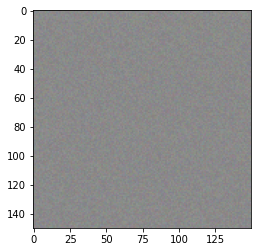

In [5]:
image_width = 150
image_height = 150
image = np.random.random((1, image_width, image_height, 3)) * 20 + 128.
image = image / 255.

plt.imshow(image[0])

In [6]:
epochs = 500
image = tf.Variable(image)

for epoch in range(epochs):
    if epoch % 100 == 0: print("epoch: {}".format(epoch))
    # 1.3a Use GradientTape to keep track of the forward passes while calculating each loss
    with tf.GradientTape() as tape:
        tape.watch(image)
        output = activation_modal(image.value())
        loss = maximization_loss(output, 15)

    # 1.3b Apply the normalized gradient to the original image
    grads = tape.gradient(loss, image)
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    image.assign_add(grads * epoch)


epoch: 0
epoch: 100
epoch: 200
epoch: 300
epoch: 400


In [7]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    # x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

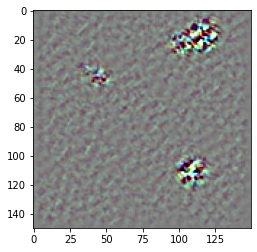

In [8]:
plt.imshow(deprocess_image(image.numpy()[0]))

In [9]:
def new_random_img():
    image_width = 150
    image_height = 150
    image = np.random.random((1, image_width, image_height, 3)) * 20 + 128.
    image = image / 255.
    return image

In [10]:
def activate_image(img, filter):
    epochs = 500
    img = tf.Variable(img)
    for epoch in range(epochs):
        # 1.3a Use GradientTape to keep track of the forward passes while calculating each loss
        with tf.GradientTape() as tape:
            tape.watch(img)
            output = activation_modal(img.value())
            loss = maximization_loss(output, filter)

        # 1.3b Apply the normalized gradient to the original image
        grads = tape.gradient(loss, img)
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
        img.assign_add(grads * epoch)
    return img

In [11]:
images_to_show = 16
filters = [random.randint(0, output_layer_filters-1) for _ in range(images_to_show)]
processed_images = []

for _, filter in enumerate(filters):
    print(filter)
    img = new_random_img()
    img = activate_image(img, filter)
    processed_images.append(img)

252
183
210
117
115
63
251
4
83
12
175
144
216
1
165
16


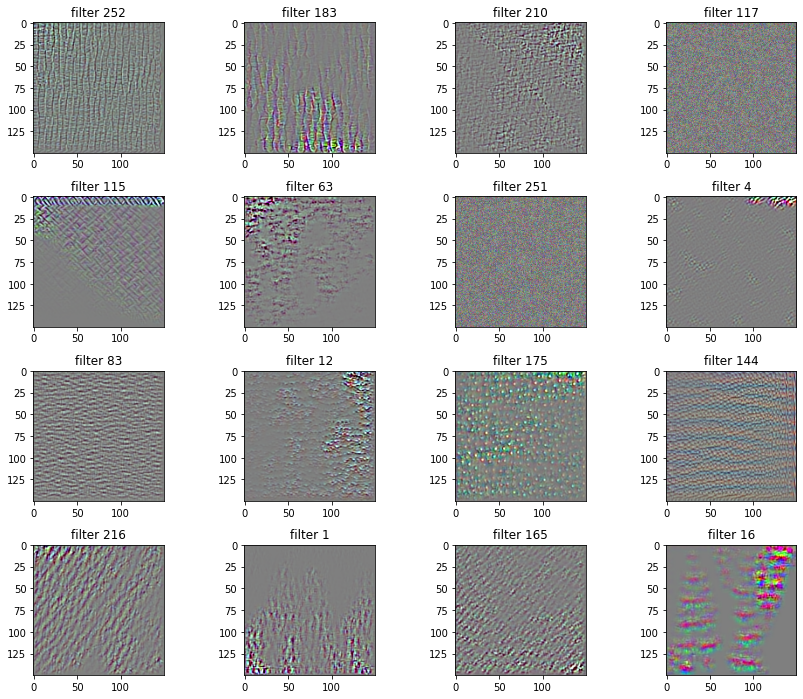

In [12]:
columns = 4
rows = (images_to_show // columns) + 1

fig = plt.figure(figsize=(12, 12))

for img_idx in range(len(processed_images)):
    img = deprocess_image(processed_images[img_idx][0].numpy())
    title = "filter {}".format(filters[img_idx])    

    img_plot = fig.add_subplot(rows, columns, img_idx+1)

    img_plot.set_title(title)
    img_plot.imshow(img)

plt.tight_layout()
plt.show(fig)